# GRU for Human Activity Recognition

Human activity recognition using smartphones dataset and an LSTM RNN. Classifying the type of movement amongst six categories:
- WALKING,
- WALKING_UPSTAIRS,
- WALKING_DOWNSTAIRS,
- SITTING,
- STANDING,
- LAYING.

Compared to a classical approach, using a Recurrent Neural Networks (RNN) with Gatet Recurent Unit cells (GRUs) require no or almost no feature engineering. Data can be fed directly into the neural network who acts like a black box, modeling the problem correctly. Other research on the activity recognition dataset used mostly use a big amount of feature engineering, which is rather a signal processing approach combined with classical data science techniques. The approach here is rather very simple in terms of how much did the data was preprocessed. 


## Details about input data

I will be using an GRU on the data to learn (as a cellphone attached on the waist) to recognise the type of activity that the user is doing. The dataset's description goes like this:

> The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. 

That said, I will use the almost raw data: only the gravity effect has been filtered out of the accelerometer  as a preprocessing step for another 3D feature as an input to help learning. 

## What is an RNN?

As explained in [this article](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), an RNN takes many input vectors to process them and output other vectors. It can be roughly pictured like in the image below, imagining each rectangle has a vectorial depth and other special hidden quirks in the image below. **In our case, the "many to one" architecture is used**: we accept time series of feature vectors (one vector per time step) to convert them to a probability vector at the output for classification. Note that a "one to one" architecture would be a standard feedforward neural network. 

<img src="http://karpathy.github.io/assets/rnn/diags.jpeg" />

An GRU is an improved RNN. It is more complex, but easier to train, avoiding what is called the vanishing gradient problem. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
from time import time
import os
import sys

In [2]:
# some reflection

def is_notebook():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter
    
if not is_notebook():
    def get_ipython():
        class Mock:
            def run_cell_magic(*args):
                pass
            def system(self, arg):
                os.system(arg)
                
        return Mock()

In [3]:
def notify(msg):
    print(msg)
    try:
        get_ipython().system('ypnotify "' + msg + '"')
    except:
        print("can't notify")

In [4]:
def find_nb_name():
    from http.server import BaseHTTPRequestHandler, HTTPServer # python3
    class HandleRequests(BaseHTTPRequestHandler):
        def do_GET(self):
            global nb_name
            nb_name = self.requestline.split()[1][1:]
            print("name is found: " + nb_name)

    import socket
    from contextlib import closing

    def find_free_port():
        with closing(socket.socket(socket.AF_INET, socket.SOCK_STREAM)) as s:
            s.bind(('',0))
            return s.getsockname()[1]

    host = ''
    port = find_free_port()
    server = HTTPServer((host, port), HandleRequests)
    server.server_activate()#.serve_forever()
    get_ipython().run_cell_magic('javascript', '', 'var i = document.createElement("img");' + 
                                 ' i.src = "http://localhost:' + str(port) + 
                                '/" + IPython.notebook.notebook_name;')
    server.handle_request()

if is_notebook():
    find_nb_name()

<IPython.core.display.Javascript object>

name is found: LSTM-2stepsA-dense=2-gru=1-only_true_accel-rotate_down-bsize=400-ewma=4-dev.ipynb


In [5]:

# standartize arguments
if is_notebook():
    sys.argv = [nb_name]
sys.argv

import argparse

parser = argparse.ArgumentParser(description='HAR task solution with limited RAM and CPU')

parser.add_argument('--nhidden', dest='n_hidden', type=int, default=16,
                    help='Amount of hidden variables in recurrent unit')
parser.add_argument('--lr', dest='lr', type=float, default=0.0015,
                    help='Learning rate')
parser.add_argument('--bsize', dest='batch_size', type=int, default=400,
                    help='batch size')
parser.add_argument('--training_iterate_dataset_times', dest='training_iterate_dataset_times', 
                    type=int, default=200, help='Loop <training_iterate_dataset_times> times on the dataset')
parser.add_argument('--ewma', dest='ewma_halflife', 
                    type=int, default=4, help='halflife in exponential smoothing and splitting to average and noise')

parser.add_argument('--use_adam', dest="use_adam", action='store_true')
parser.add_argument('--use_rmsprop', dest="use_rmsprop", action='store_true')

args = parser.parse_args()
print(args)



Namespace(batch_size=400, ewma_halflife=4, lr=0.0015, n_hidden=16, training_iterate_dataset_times=200, use_adam=False, use_rmsprop=False)


In [6]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "total_acc_x_", "total_acc_y_", "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 


## Let's start by downloading the data: 

In [7]:
# Note: Linux bash commands start with a "!" inside those "ipython notebook" cells

DATA_PATH = "data/"

os.chdir(DATA_PATH)
!python download_dataset.py
os.chdir("..")

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)



Downloading...
Dataset already downloaded. Did not download twice.

Extracting...
Dataset already extracted. Did not extract twice.


Dataset is now located at: data/UCI HAR Dataset/


In [8]:
pd.read_csv("data/UCI HAR Dataset/test/Inertial Signals/total_acc_x_test.txt", 
            header=None, sep=' ', skipinitialspace=True).values.shape

(2947, 128)

## Preparing dataset:

In [9]:
# Load "X" (the neural network's training and testing inputs)
def load_X(signals_paths):
    X_signals = [pd.read_csv(path, header=None, sep=' ', skipinitialspace=True).values
                 for path in signals_paths] 
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train = load_X([DATASET_PATH + "train/Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES])
X_test = load_X([DATASET_PATH + "test/Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES])

# Load "y" (the neural network's training and testing outputs)
def load_y(path):
    return pd.read_csv(path, header=None, sep=' ', skipinitialspace=True).values - 1

make_y_easier_m = [0, 1, 1, 3, 3, 3]
def make_y_easier(y):
    return np.array([make_y_easier_m[int(i)] for i in y])

y_train = load_y(DATASET_PATH + "train/y_train.txt")
y_easier_train = make_y_easier(y_train)
y_test = load_y(DATASET_PATH + "test/y_test.txt")
y_easier_test = make_y_easier(y_test)

In [10]:
def shuffle_all(*args):
    perm = np.random.permutation(len(args[0]))
    return [np.array(arg)[perm] for arg in args]

X_train, y_train, y_easier_train = shuffle_all(X_train, y_train, y_easier_train)

In [11]:
from sklearn.decomposition import PCA

def calc_rotation_zero_not_first(h):
    h = np.array(h)
    
    # max axis to first position
    gci = np.argmax(np.abs(h))
    fmax_m = np.matrix(np.diag([1, 1, 1]))
    if gci != 0:
        fmax_m[0], fmax_m[gci] = np.matrix(fmax_m[gci]), np.matrix(fmax_m[0])
        fmax_m *= -1
    h = np.array(fmax_m * np.matrix(h).T).ravel()
    
    #make first axis positive
    fsign_m = np.matrix(np.diag([(1 if h[0] > 0 else -1)] * 2 + [1]))
    h = np.array(fsign_m * np.matrix(h).T).ravel()
    
    # zero second
    phi = np.arctan2(h[2], h[0])
    s, c = np.sin(phi), np.cos(phi)
    zero2nd_m = np.matrix(np.array([
        [c, 0, s],
        [0, 1, 0],
        [-s, 0, c],
    ]))
    h = np.array(zero2nd_m * np.matrix(h).T).ravel()
    
    # zero first
    phi = np.arctan2(h[1], h[0])
    s, c = np.sin(phi), np.cos(phi)
    zero1st_m = np.matrix(np.array([
        [c, s, 0],
        [-s, c, 0],
        [0, 0, 1],
    ]))
    h = np.array(zero1st_m * np.matrix(h).T).ravel()
    
    final_rotation = zero1st_m * zero2nd_m * fsign_m * fmax_m
    
    return final_rotation
    
#print(calc_rotation_zero_not_first(np.array([1, 2, 3])))

def align_0th(xyz):
    xyz = np.array(xyz)
    h = xyz.mean(axis=0)
    m = calc_rotation_zero_not_first(h)
    return np.array(m * np.matrix(xyz).T).T

def align_determ(xyz):
    xyz = align_0th(xyz)
    pcator = PCA(n_components=2)
    pcator.fit(xyz[:, 1:3])
    xyz[:, 1:3] = pcator.transform(xyz[:, 1:3])
    return xyz

def split_avg_noise(xyz):
    smoothed = pd.ewma(pd.DataFrame(xyz), halflife=args.ewma_halflife).values
    return smoothed, xyz - smoothed

In [12]:
if is_notebook() and False:
    def show_serie(i):
        display(LABELS[int(y_train[i])])

        pd.DataFrame(X_train[i, :, 0:3] - split_avg_noise(X_train[i, :, 0:3])).plot(figsize=(10, 10))
        plt.show()
        
        pd.DataFrame(X_train[i, :, 0:3]).plot(figsize=(10, 10))
        plt.show()
   
    show_serie(0)
    show_serie(101)

In [13]:
def align_X(X):
    X = np.array(X)
    if args.ewma_halflife != 0:
        Y = np.array(X)
        for i in range(X.shape[0]):
            X[i], Y[i] = split_avg_noise(X[i])
        X = np.concatenate([X, Y], axis=2)
    else:
        for i in range(X.shape[0]):
            X[i] = align_determ(X[i])
    return X
    
X_train = align_X(X_train)
X_test = align_X(X_test)
print(X_train.shape)

LSTM-2stepsA-dense=2-gru=1-only_true_accel-rotate_down-bsize=400-ewma=4-dev.ipynb:58: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(min_periods=0,adjust=True,ignore_na=False,halflife=4).mean()
  "outputs": [],


(7352, 128, 6)


## Additionnal Parameters:

Here are some core parameter definitions for the training. 

The whole neural network's structure could be summarised by enumerating those parameters and the fact an LSTM is used. 

In [14]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 3 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = args.n_hidden # Hidden layer num of features
n_classes = y_test.max() + 1 # 6 - total classes (should go up, or should go down)
n_easier_classes = y_easier_test.max() + 1 # also 6

# Training 

learning_rate = args.lr
lambda_loss_amount = 0.0015
training_iters = training_data_count * args.training_iterate_dataset_times
batch_size = args.batch_size
display_iter = 50  # To show test set accuracy during training

# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")


Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 6) (2947, 1) 0.150380533658 0.400546802256
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


## Utility functions for training:

In [15]:
def MAKE_RNN(_X, tdep):
    # Function returns a tensorflow GRU (RNN) artificial neural network from given parameters. 
    # input shape: (batch_size, n_steps, n_input)
    
    # Linear activation
    _X = tf.layers.dense(_X, n_hidden, activation=tf.nn.relu)
    
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.unstack(_X, n_steps, 1)
    
    gru_cell_1 = tf.contrib.rnn.GRUCell(n_hidden, activation=tf.nn.relu)
    rnn_cells = tf.contrib.rnn.MultiRNNCell([gru_cell_1], state_is_tuple=True)
    
    outputs, states = tf.contrib.rnn.static_rnn(rnn_cells, _X, dtype=tf.float32)

    #rnn_last_output = outputs[-1]
    
    rnn_output = tf.stack(outputs, axis=1)
    before_split = tf.layers.dense(rnn_output, n_classes * 2)
    result = tf.layers.dense(before_split, n_classes)
    
    
    pred = tf.transpose(result, [0, 2, 1])  # permute n_steps and batch_size
    print(pred.shape)
    pred = pred * tdep
    #tf.constant((0.9 ** np.arange(0, n_steps, 1))[::-1], dtype=tf.float32) 
    print(pred.shape)
    pred = tf.reduce_sum(pred, 2)
    print(pred.shape)
    
    #pred = tf.unstack(result, n_steps, 1)[-1]
    pred_easier = tf.layers.dense(outputs[-1], n_classes)
    
    return pred, pred_easier, result
    
    
    #before_split = tf.layers.dense(rnn_last_output, n_classes * 2)
    #return tf.layers.dense(before_split, n_classes), tf.layers.dense(rnn_last_output, n_classes)
    

def extract_batch(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_, n_values=n_classes):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

def extract_batch_xy(x, y, step, batch_size):
    return extract_batch(x, step, batch_size), one_hot(extract_batch(y, step, batch_size))

## Let's get serious and build the neural network:

In [16]:
from collections import namedtuple

class TfVars:
    def __init__(self):
        crossentropy = tf.nn.softmax_cross_entropy_with_logits
        self.OptClass = tf.train.RMSPropOptimizer
        if args.use_adam:
            self.OptClass = tf.train.AdamOptimizer
    
        # Graph input/output
        self.x = tf.placeholder(tf.float32, [None, n_steps, n_input])
        self.y = tf.placeholder(tf.float32, [None, n_classes])
        self.lr = tf.placeholder(tf.float32, shape=[])
        
        self.tdep = tf.Variable(tf.random_normal([n_steps]))
        
        pred, pred_easier, self.normal_pred_log = MAKE_RNN(self.x, self.tdep) 
        
        self.LearnVariant = namedtuple('LearnVariant', ['cost', 'optimizer', "accuracy", "tfv", "pred"])
        
        def cost_opt_acc(pred):
            cost = tf.reduce_mean(crossentropy(labels=self.y, logits=pred))
            opt = self.OptClass(learning_rate=self.lr).minimize(cost)
            pred_c = tf.equal(tf.argmax(pred,1), tf.argmax(self.y,1))
            acc = tf.reduce_mean(tf.cast(pred_c, tf.float32))
            return self.LearnVariant(cost=cost, optimizer=opt, accuracy=acc, tfv = self, pred=pred)
        
        self.normal = cost_opt_acc(pred)
        self.easier = cost_opt_acc(pred_easier)
        
tfv = TfVars()

(?, 6, 128)
(?, 6, 128)
(?, 6)


In [17]:
help(tf.nn.softmax)

Help on function softmax in module tensorflow.python.ops.nn_ops:

softmax(logits, dim=-1, name=None)
    Computes softmax activations.
    
    For each batch `i` and class `j` we have
    
        softmax = exp(logits) / reduce_sum(exp(logits), dim)
    
    Args:
      logits: A non-empty `Tensor`. Must be one of the following types: `half`,
        `float32`, `float64`.
      dim: The dimension softmax would be performed on. The default is -1 which
        indicates the last dimension.
      name: A name for the operation (optional).
    
    Returns:
      A `Tensor`. Has the same type as `logits`. Same shape as `logits`.
    Raises:
      InvalidArgumentError: if `logits` is empty or `dim` is beyond the last
        dimension of `logits`.



## Hooray, now train the neural network:
### First stage of training (easier):

In [18]:
# Launch the graph
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=False))
init = tf.global_variables_initializer()
sess.run(init)

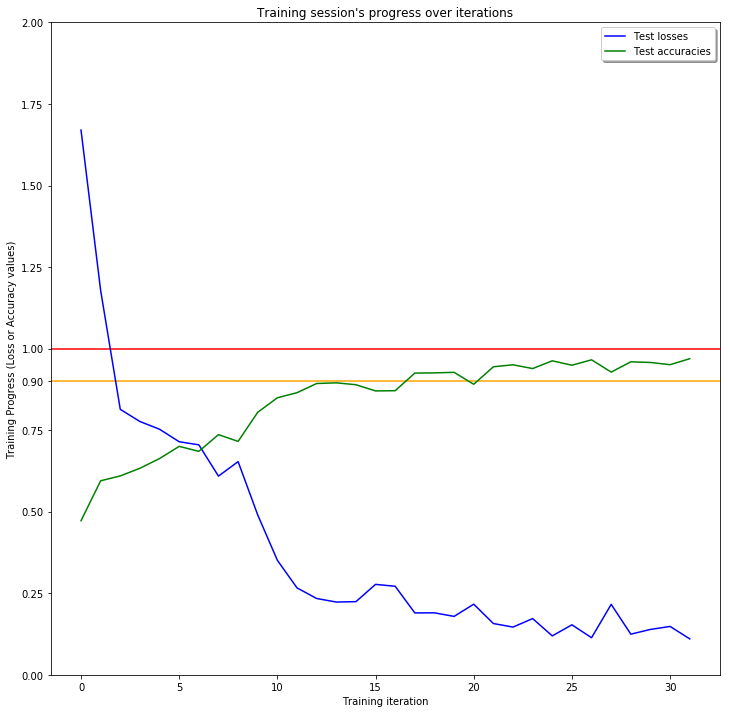

Training iter #640000Accuracy = 0.9824999570846558
PERFORMANCE ON TEST SET: Accuracy = 0.9691210985183716


KeyboardInterrupt: 

In [19]:
start_learning_time = time()

from IPython.display import clear_output
#To keep track of training's performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []


def learn(variant, bx, by):
    _, loss, acc = sess.run(
        [variant.optimizer, variant.cost, variant.accuracy],
        feed_dict={
            variant.tfv.x: bx, 
            variant.tfv.y: by,
            variant.tfv.lr: learning_rate
        }
    )
    return loss, acc

def estimate_on_test(variant, ans):
    return sess.run(
        [variant.cost, variant.accuracy], 
        feed_dict={
            variant.tfv.x: X_test,
            variant.tfv.y: one_hot(ans)
        }
    )

def init_default_plot():
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(1, 1, 1)
    
    plt.axhline(y=1.0, c='r')
    plt.axhline(y=0.9, c='orange')
    plt.ylim(0, 2)
    
    ax.set_yticks(list(ax.get_yticks()) + [0.9])


    
# Perform Training steps with "batch_size" amount of example data at each loop
step = 1
diter = 0
while step * batch_size <= training_iters:
    batch_xs, batch_ys = extract_batch_xy(X_train, y_easier_train, step, batch_size)

    # Fit training using batch data
    loss, acc = learn(tfv.easier, batch_xs, batch_ys)
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if is_notebook() and step % display_iter == 0:
        diter += 1
        # To not spam console, show training accuracy/loss in this "if"
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        test_loss, test_acc = estimate_on_test(tfv.easier, y_easier_test)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        clear_output(True)

        init_default_plot()
        
        ixs = np.array(range(diter))
        plt.plot(ixs, np.array(test_losses),     "b-", label="Test losses")
        plt.plot(ixs, np.array(test_accuracies), "g-", label="Test accuracies")

        plt.title("Training session's progress over iterations")
        plt.legend(loc='upper right', shadow=True)
        plt.ylabel('Training Progress (Loss or Accuracy values)')
        plt.xlabel('Training iteration')

        plt.show()
        
        print("Training iter #" + str(step * batch_size) + \
              "Accuracy = {}".format(acc))

        print("PERFORMANCE ON TEST SET: " + \
              "Accuracy = {}".format(test_acc))
    
    if step % int(X_train.shape[0] / batch_size) == 0:
        X_train, y_train, y_easier_train = shuffle_all(X_train, y_train, y_easier_train)
        
    step += 1

# change task
step = 1
while step * batch_size <= training_iters and False:
    batch_xs, batch_ys = extract_batch_xy(X_train, y_easier_train, step, batch_size)

    # Fit training using batch data
    loss, acc = learn(tfv.easier, batch_xs, 5 - batch_ys)
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if is_notebook() and step % display_iter == 0:
        diter += 1
        # To not spam console, show training accuracy/loss in this "if"
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        test_loss, test_acc = estimate_on_test(tfv.easier, 5 - y_easier_test)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        clear_output(True)

        init_default_plot()
        
        ixs = np.array(range(diter))
        plt.plot(ixs, np.array(test_losses),     "b-", label="Test losses")
        plt.plot(ixs, np.array(test_accuracies), "g-", label="Test accuracies")

        plt.title("Training session's progress over iterations")
        plt.legend(loc='upper right', shadow=True)
        plt.ylabel('Training Progress (Loss or Accuracy values)')
        plt.xlabel('Training iteration')

        plt.show()
        
        print("Training iter #" + str(step * batch_size) + \
              " Accuracy = {}".format(acc))

        print("PERFORMANCE ON TEST SET: " + \
              "Accuracy = {}".format(test_acc))
    
    if step % int(X_train.shape[0] / batch_size) == 0:
        X_train, y_train, y_easier_train = shuffle_all(X_train, y_train, y_easier_train)
        
    step += 1

print("Optimization Finished!")

# Accuracy for test data

test_loss, test_acc = estimate_on_test(tfv.easier, y_easier_test)
test_losses.append(test_loss)
test_accuracies.append(test_acc)

notify("INTERMEDIATE RESULT: " + \
      "Accuracy = {}".format(test_acc))

### Second stage (normal)

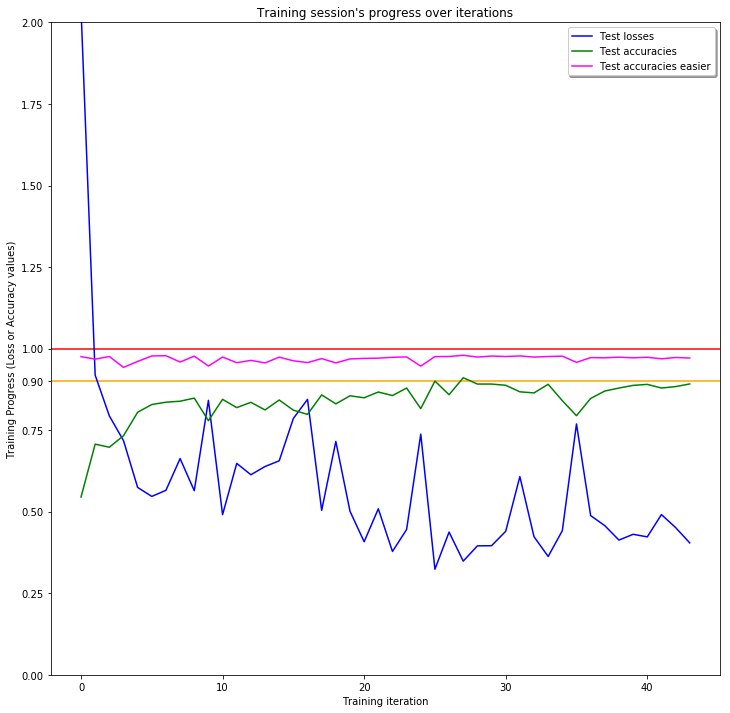

Training iter #880000 Accuracy = 0.9650000333786011
PERFORMANCE ON TEST SET: Accuracy = 0.8917542695999146, Accuracy easier = 0.9711570143699646


KeyboardInterrupt: 

In [20]:
test_losses = []
test_accuracies = []
test_losses_easier = []
test_accuracies_easier = []
train_losses = []
train_accuracies = []

# Perform Training steps with "batch_size" amount of example data at each loop
step = 1
diter = 0
training_iters2 = training_iters * 2

while step * batch_size <= training_iters2:
    batch_xs, batch_ys = extract_batch_xy(X_train, y_train, step, batch_size)

    # period of moving from easy task to normal task
    if step * batch_size <= training_iters2 / 4:
        _, batch_ys_easier = extract_batch_xy(X_train, y_easier_train, step, batch_size)
        learn(tfv.easier, batch_xs, batch_ys_easier)
    
    # Fit training using batch data
    loss, acc = learn(tfv.normal, batch_xs, batch_ys)
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if is_notebook() and step % display_iter == 0:
        diter += 1
        # To not spam console, show training accuracy/loss in this "if"
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        test_loss, test_acc = estimate_on_test(tfv.normal, y_test)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        test_loss_easier, test_acc_easier = estimate_on_test(tfv.easier, y_easier_test)
        test_losses_easier.append(test_loss_easier)
        test_accuracies_easier.append(test_acc_easier)
        
        clear_output(True)

        init_default_plot()
        
        ixs = np.array(range(diter))
        plt.plot(ixs, np.array(test_losses),     "b-", label="Test losses")
        plt.plot(ixs, np.array(test_accuracies), "g-", label="Test accuracies")
        
        plt.plot(ixs, np.array(test_accuracies_easier), "magenta", label="Test accuracies easier")

        plt.title("Training session's progress over iterations")
        plt.legend(loc='upper right', shadow=True)
        plt.ylabel('Training Progress (Loss or Accuracy values)')
        plt.xlabel('Training iteration')

        plt.show()
        
        print("Training iter #" + str(step * batch_size) +
              " Accuracy = {}".format(acc))

        print("PERFORMANCE ON TEST SET: " +
              "Accuracy = {}".format(test_acc) +
              ", Accuracy easier = {}".format(test_acc_easier))
    
    if step % int(X_train.shape[0] / batch_size) == 0:
        X_train, y_train, y_easier_train = shuffle_all(X_train, y_train, y_easier_train)
        
    step += 1

print("Optimization Finished!")

# Accuracy for test data

test_loss, test_acc = estimate_on_test(tfv.normal, y_test)
test_losses.append(test_loss)
test_accuracies.append(test_acc)

notify("FINAL RESULT: " + \
      "Accuracy = {}".format(test_acc))

In [ ]:
if not is_notebook():
    test_loss, test_acc = estimate_on_test(tfv.normal, y_test)
    
    argsdict = dict(args.__dict__)
    argsdict.update({
        "accuracy": float(test_acc),
        "time": float(time() - start_learning_time),
        "memory": sum(int(np.prod(var.shape)) for var in tf.trainable_variables()) * 4,
    })
    print("RESULT " + str(argsdict))
    exit(0)

[133 134 135 136 137 138 139 140 141 142]


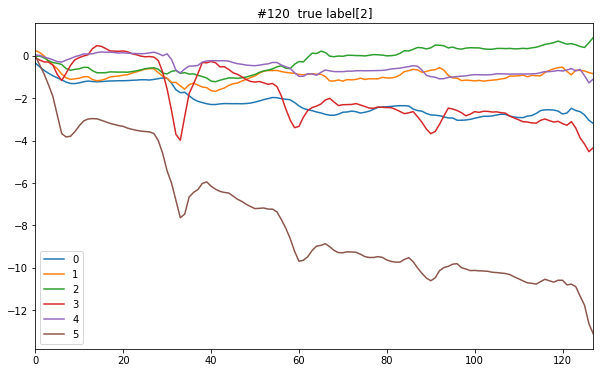

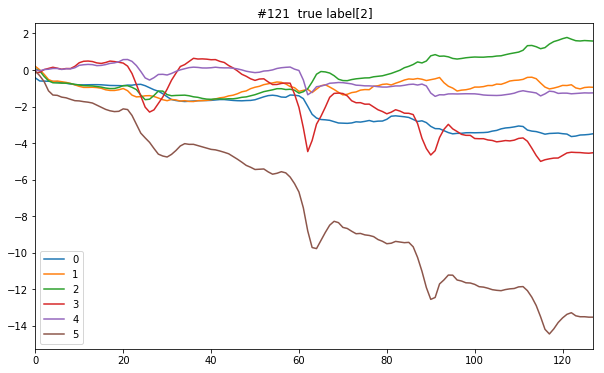

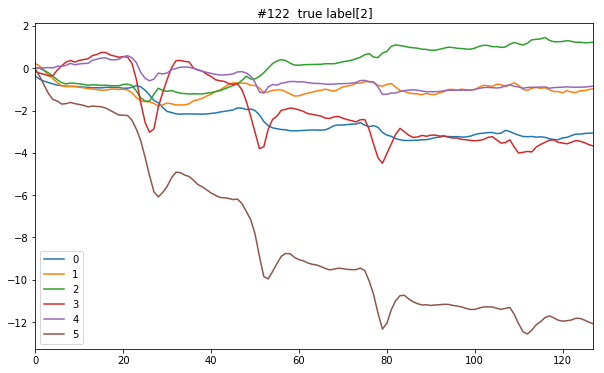

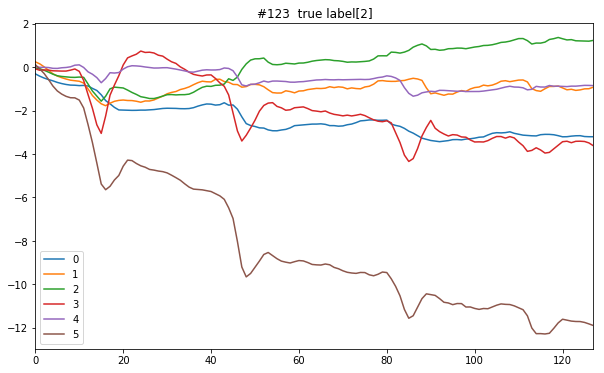

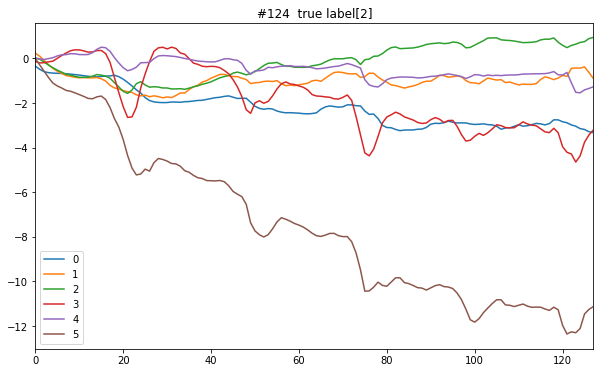

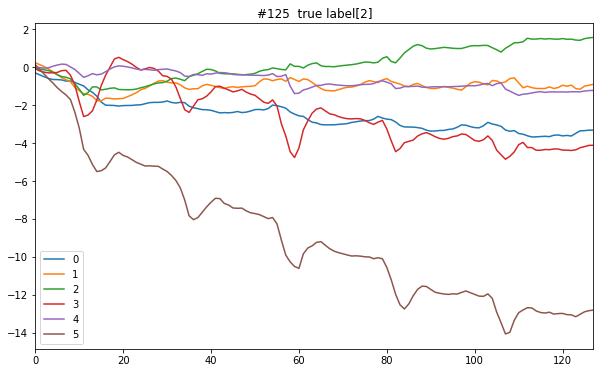

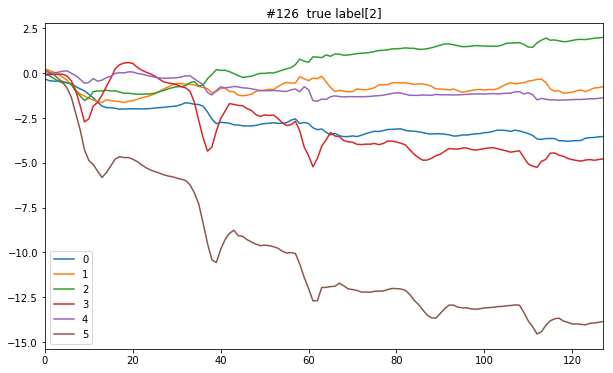

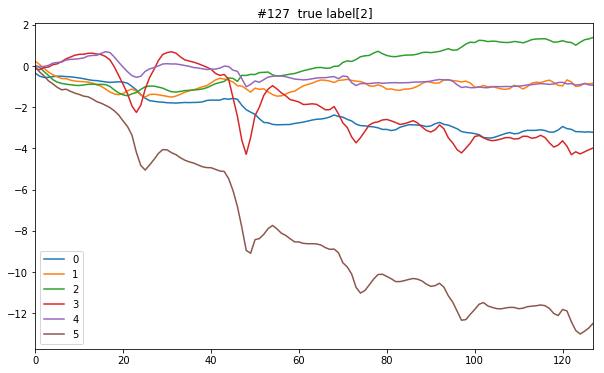

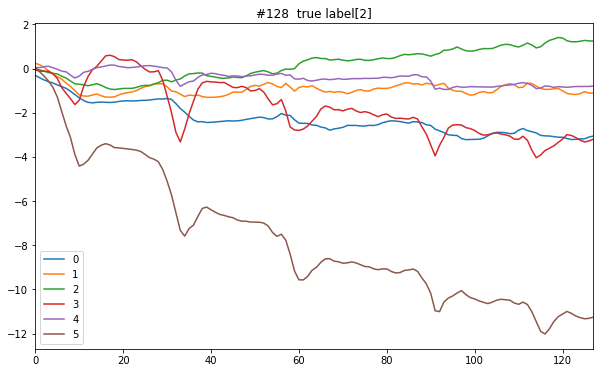

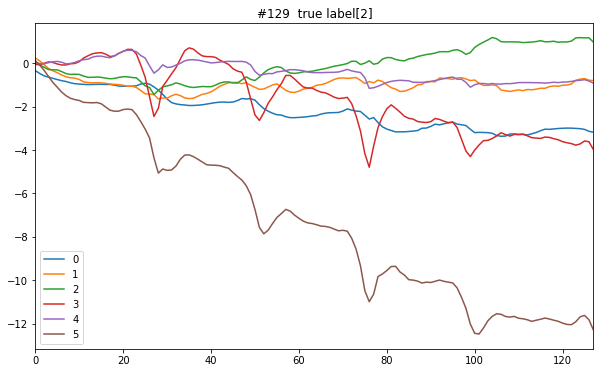

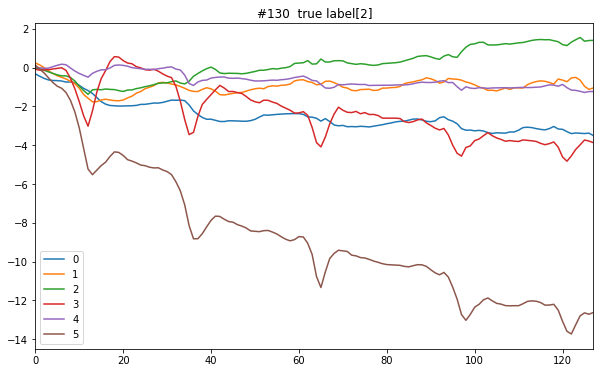

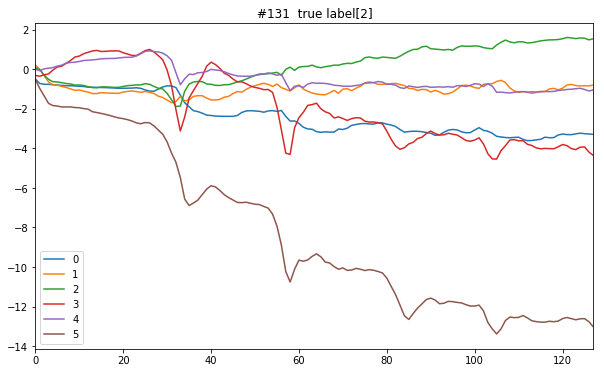

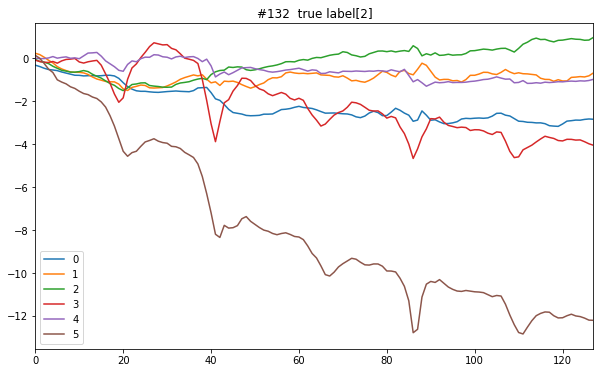

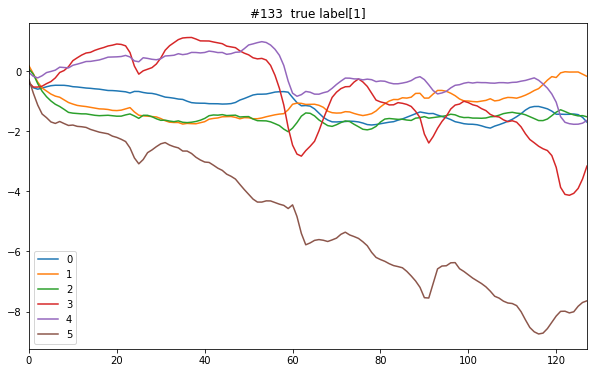

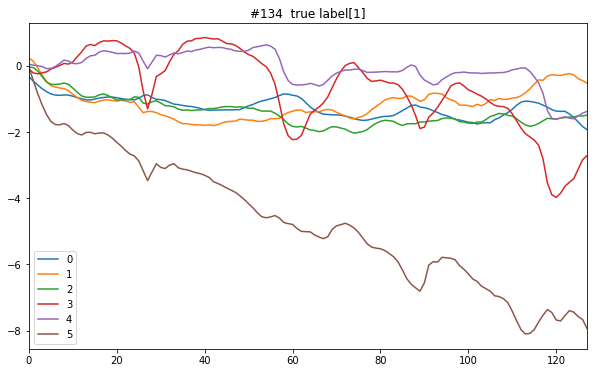

In [21]:
test_pred_log = sess.run(
    [tfv.normal_pred_log], 
    feed_dict={
        tfv.x: X_test
    }
)[0]

def watch_log(i):
    pd.DataFrame(test_pred_log[i]).plot(figsize=(10, 6))
    plt.title("#" + str(i) + "  true label" + str(y_test[i]))
    plt.show()
    
print(np.where(y_test == 1)[0][:10])
    
for i in range(120, 135):
    watch_log(i)

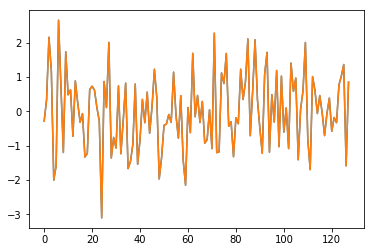

In [24]:
plt.plot(sess.run(tfv.tdep))
plt.show()

## Training is good, but having visual insight is even better:

Okay, let's plot this simply in the notebook for now.

In [ ]:
# (Inline plots: )
%matplotlib inline

font = {
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = range(len(test_losses))
plt.plot(indep_test_axis, np.array(test_losses),     "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.axhline(y=1.0, c='r')
plt.axhline(y=0.9, c='orange')

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')
plt.ylim(0, 2)
plt.show()

## And finally, the multi-class confusion matrix and metrics!

In [ ]:
# Results

one_hot_predictions = np.array(sess.run(
    [tfv.normal.pred], 
    feed_dict={
        tfv.x: X_test,
        tfv.y: one_hot(y_test)
    }
))
one_hot_predictions.shape = one_hot_predictions.shape[1:]

print(one_hot_predictions.shape)
predictions = one_hot_predictions.argmax(axis=1)

print("Testing Accuracy: {}%".format(100*test_acc))

print(predictions.shape)

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
sess.close()

## Conclusion

Outstandingly, **the final accuracy is of about 90%** (depends of launch)!

This means that the neural networks is almost always able to correctly identify the movement type! Remember, the phone is attached on the waist and each series to classify has just a 128 sample window of two internal sensors (a.k.a. 2.56 seconds at 50 FPS), so those predictions are extremely accurate.

I specially did not expect such good results for guessing between "SITTING" and "STANDING". Those are seemingly almost the same thing from the point of view of a device placed at waist level according to how the dataset was gathered. Thought, it is still possible to see a little cluster on the matrix between those classes, which drifts away from the identity. This is great.

It is also possible to see that there was a slight difficulty in doing the difference between "WALKING", "WALKING_UPSTAIRS" and "WALKING_DOWNSTAIRS". Obviously, those activities are quite similar in terms of movements. 

In [ ]:
get_ipython().system("jupyter nbconvert --to markdown " + nb_name)
get_ipython().system("jupyter nbconvert --to python " + nb_name)
display(nb_name)
pyname = nb_name[:-6] + ".py"
display(pyname)

In [ ]:
raise KeyboardInterrupt("do not automatically run after it")

## Parameters selection

In [ ]:
import pandas as pd
def dict_protocol_to_dataframe(protocol):
    return pd.read_json('[' + protocol.replace("'", '"').replace('\n', ',')
                                      .replace('True', 'true').replace('False', 'false')+ ']')

dict_protocol_to_dataframe("""\
{'time': 548.2270517349243, 'n_hidden': 1, 'lr': 0.0025, 'accuracy': 0.6878181099891663, 'memory': 532, 'batch_size': 2000, 'training_iterate_dataset_times': 200}
{'lr': 0.0025, 'training_iterate_dataset_times': 200, 'n_hidden': 2, 'batch_size': 2000, 'accuracy': 0.7770613431930542, 'memory': 728, 'time': 566.6135125160217}\
""")

In [ ]:
#bench hhidden
bench_cmd = """
for i in {1..25}; do \
    python3 %s \
    --nhidden $i --training_iterate_dataset_times 200\
    2> full_bench.err \
    | tee -a full_bench.log \
    | grep -e "^RESULT" | cut -c 8- \
    | tee -a bench.log; \
done
""" % pyname
get_ipython().system("bash -c '" + bench_cmd + "'")

In [ ]:
bench_nhidden_protocol = """\
{'n_hidden': 1, 'memory': 508, 'accuracy': 0.6627078056335449, 'batch_size': 800, 'use_rmsprop': False, 'use_adam': False, 'training_iterate_dataset_times': 200, 'lr': 0.0025, 'time': 772.0379655361176}
{'use_rmsprop': False, 'training_iterate_dataset_times': 200, 'use_adam': False, 'accuracy': 0.5758398175239563, 'n_hidden': 2, 'time': 720.3474073410034, 'batch_size': 800, 'memory': 680, 'lr': 0.0025}
{'memory': 900, 'accuracy': 0.6057007312774658, 'n_hidden': 3, 'batch_size': 800, 'use_rmsprop': False, 'lr': 0.0025, 'training_iterate_dataset_times': 200, 'use_adam': False, 'time': 662.5361175537109}
{'accuracy': 0.6674584150314331, 'time': 655.1994025707245, 'training_iterate_dataset_times': 200, 'memory': 1168, 'use_adam': False, 'lr': 0.0025, 'batch_size': 800, 'use_rmsprop': False, 'n_hidden': 4}
{'batch_size': 800, 'memory': 1484, 'accuracy': 0.5341024398803711, 'n_hidden': 5, 'training_iterate_dataset_times': 200, 'lr': 0.0025, 'time': 678.890563249588, 'use_rmsprop': False, 'use_adam': False}
{'n_hidden': 6, 'use_adam': False, 'accuracy': 0.6016287207603455, 'memory': 1848, 'use_rmsprop': False, 'lr': 0.0025, 'training_iterate_dataset_times': 200, 'batch_size': 800, 'time': 674.8454222679138}
{'batch_size': 800, 'use_adam': False, 'use_rmsprop': False, 'lr': 0.0025, 'time': 669.8843955993652, 'accuracy': 0.7003732323646545, 'training_iterate_dataset_times': 200, 'n_hidden': 7, 'memory': 2260}
{'accuracy': 0.751272439956665, 'memory': 2720, 'use_adam': False, 'training_iterate_dataset_times': 200, 'time': 660.9931690692902, 'n_hidden': 8, 'use_rmsprop': False, 'batch_size': 800, 'lr': 0.0025}
{'accuracy': 0.5656599998474121, 'time': 707.3295772075653, 'lr': 0.0025, 'batch_size': 800, 'training_iterate_dataset_times': 200, 'use_adam': False, 'n_hidden': 9, 'memory': 3228, 'use_rmsprop': False}
{'batch_size': 800, 'training_iterate_dataset_times': 200, 'n_hidden': 10, 'time': 715.7435595989227, 'lr': 0.0025, 'memory': 3784, 'accuracy': 0.6973192691802979, 'use_rmsprop': False, 'use_adam': False}
{'training_iterate_dataset_times': 200, 'lr': 0.0025, 'time': 732.3185958862305, 'use_rmsprop': False, 'n_hidden': 11, 'accuracy': 0.6430268287658691, 'use_adam': False, 'memory': 4388, 'batch_size': 800}
{'batch_size': 800, 'accuracy': 0.7360026836395264, 'n_hidden': 12, 'use_adam': False, 'lr': 0.0025, 'use_rmsprop': False, 'memory': 5040, 'time': 742.9097394943237, 'training_iterate_dataset_times': 200}
{'use_adam': False, 'memory': 5740, 'time': 760.5904695987701, 'training_iterate_dataset_times': 200, 'batch_size': 800, 'lr': 0.0025, 'use_rmsprop': False, 'accuracy': 0.6942652463912964, 'n_hidden': 13}
{'use_rmsprop': False, 'training_iterate_dataset_times': 200, 'memory': 6488, 'lr': 0.0025, 'batch_size': 800, 'time': 776.510192155838, 'n_hidden': 14, 'accuracy': 0.8008143901824951, 'use_adam': False}
{'lr': 0.0025, 'n_hidden': 15, 'time': 790.9602189064026, 'memory': 7284, 'batch_size': 800, 'training_iterate_dataset_times': 200, 'use_adam': False, 'accuracy': 0.7488970756530762, 'use_rmsprop': False}
{'lr': 0.0025, 'n_hidden': 16, 'use_rmsprop': False, 'memory': 8128, 'use_adam': False, 'batch_size': 800, 'time': 796.3274857997894, 'training_iterate_dataset_times': 200, 'accuracy': 0.7492364645004272}
{'use_adam': False, 'time': 979.4974310398102, 'training_iterate_dataset_times': 200, 'n_hidden': 17, 'accuracy': 0.8154054880142212, 'memory': 9020, 'batch_size': 800, 'use_rmsprop': False, 'lr': 0.0025}
{'use_adam': False, 'use_rmsprop': False, 'n_hidden': 18, 'memory': 9960, 'batch_size': 800, 'accuracy': 0.819477379322052, 'lr': 0.0025, 'training_iterate_dataset_times': 200, 'time': 998.5558381080627}
{'memory': 10948, 'n_hidden': 19, 'use_adam': False, 'training_iterate_dataset_times': 200, 'lr': 0.0025, 'accuracy': 0.7227687835693359, 'time': 1023.3071684837341, 'batch_size': 800, 'use_rmsprop': False}
{'accuracy': 0.6416694521903992, 'memory': 11984, 'lr': 0.0025, 'use_rmsprop': False, 'time': 1031.0319290161133, 'batch_size': 800, 'training_iterate_dataset_times': 200, 'use_adam': False, 'n_hidden': 20}
{'lr': 0.0025, 'batch_size': 800, 'memory': 13068, 'time': 1062.1775381565094, 'training_iterate_dataset_times': 200, 'accuracy': 0.6420088410377502, 'use_rmsprop': False, 'n_hidden': 21, 'use_adam': False}
{'use_adam': False, 'lr': 0.0025, 'training_iterate_dataset_times': 200, 'time': 1144.7650830745697, 'memory': 14200, 'n_hidden': 22, 'batch_size': 800, 'use_rmsprop': False, 'accuracy': 0.6321682333946228}
{'training_iterate_dataset_times': 200, 'use_adam': False, 'lr': 0.0025, 'memory': 15380, 'time': 1155.4969289302826, 'n_hidden': 23, 'accuracy': 0.7919918298721313, 'batch_size': 800, 'use_rmsprop': False}
{'n_hidden': 24, 'use_rmsprop': False, 'memory': 16608, 'batch_size': 800, 'training_iterate_dataset_times': 200, 'accuracy': 0.634882926940918, 'time': 1172.9154741764069, 'lr': 0.0025, 'use_adam': False}
{'time': 1240.9481527805328, 'use_rmsprop': False, 'memory': 17884, 'accuracy': 0.831693172454834, 'batch_size': 800, 'training_iterate_dataset_times': 200, 'n_hidden': 25, 'lr': 0.0025, 'use_adam': False}"""

data = dict_protocol_to_dataframe(bench_nhidden_protocol)
data = data.set_index('n_hidden')

data[["accuracy", "memory", "time"]].plot(subplots=True, figsize=(10,15), title="Selecting nhidden")
plt.show()

In [ ]:
#bench hhidden
bench_cmd = """
for i in %s; do \
    python3 %s \
    --lr $i --training_iterate_dataset_times 200\
    2> full_bench.err \
    | tee -a full_bench.log \
    | grep -e "^RESULT" | cut -c 8- \
    | tee -a bench.log; \
done
""" % (" ".join(map(str, np.arange(0.0005, 0.005, 0.0002))), pyname)
get_ipython().system("bash -c '" + bench_cmd + "'")

In [ ]:
bench_nhidden_protocol = """\
{'training_iterate_dataset_times': 200, 'time': 794.8192670345306, 'n_hidden': 16, 'use_rmsprop': False, 'memory': 8128, 'lr': 0.0005, 'batch_size': 800, 'use_adam': False, 'accuracy': 0.7037665247917175}
{'n_hidden': 16, 'use_rmsprop': False, 'time': 791.1197946071625, 'lr': 0.0007, 'batch_size': 800, 'training_iterate_dataset_times': 200, 'accuracy': 0.7231082320213318, 'memory': 8128, 'use_adam': False}
{'lr': 0.0009, 'batch_size': 800, 'use_adam': False, 'training_iterate_dataset_times': 200, 'accuracy': 0.809297502040863, 'memory': 8128, 'use_rmsprop': False, 'n_hidden': 16, 'time': 795.8083786964417}
{'batch_size': 800, 'memory': 8128, 'time': 794.4841299057007, 'use_rmsprop': False, 'training_iterate_dataset_times': 200, 'accuracy': 0.7885985374450684, 'n_hidden': 16, 'use_adam': False, 'lr': 0.0011}
{'memory': 8128, 'use_rmsprop': False, 'lr': 0.0013, 'batch_size': 800, 'use_adam': False, 'n_hidden': 16, 'training_iterate_dataset_times': 200, 'accuracy': 0.7862231731414795, 'time': 792.6490998268127}
{'batch_size': 800, 'memory': 8128, 'use_rmsprop': False, 'time': 808.8380537033081, 'training_iterate_dataset_times': 200, 'n_hidden': 16, 'accuracy': 0.7356632947921753, 'lr': 0.0015, 'use_adam': False}
{'memory': 8128, 'use_rmsprop': False, 'training_iterate_dataset_times': 200, 'lr': 0.0017, 'time': 816.4750707149506, 'use_adam': False, 'accuracy': 0.5914489030838013, 'batch_size': 800, 'n_hidden': 16}
{'use_adam': False, 'accuracy': 0.6627078056335449, 'use_rmsprop': False, 'time': 821.1141517162323, 'training_iterate_dataset_times': 200, 'batch_size': 800, 'memory': 8128, 'n_hidden': 16, 'lr': 0.0019}
{'n_hidden': 16, 'use_rmsprop': False, 'lr': 0.0021, 'time': 810.5998747348785, 'accuracy': 0.7943670749664307, 'memory': 8128, 'use_adam': False, 'training_iterate_dataset_times': 200, 'batch_size': 800}
{'time': 816.5132377147675, 'use_adam': False, 'use_rmsprop': False, 'memory': 8128, 'training_iterate_dataset_times': 200, 'accuracy': 0.8266032934188843, 'n_hidden': 16, 'lr': 0.0023, 'batch_size': 800}
{'lr': 0.0025, 'n_hidden': 16, 'use_adam': False, 'memory': 8128, 'accuracy': 0.7315914034843445, 'use_rmsprop': False, 'batch_size': 800, 'training_iterate_dataset_times': 200, 'time': 810.8860170841217}
{'training_iterate_dataset_times': 200, 'batch_size': 800, 'time': 816.7522842884064, 'n_hidden': 16, 'use_rmsprop': False, 'lr': 0.0027, 'memory': 8128, 'accuracy': 0.6118085980415344, 'use_adam': False}
{'use_adam': False, 'memory': 8128, 'n_hidden': 16, 'use_rmsprop': False, 'accuracy': 0.8361043930053711, 'time': 815.2302830219269, 'training_iterate_dataset_times': 200, 'batch_size': 800, 'lr': 0.0029}
{'n_hidden': 16, 'time': 815.0186021327972, 'lr': 0.0031, 'training_iterate_dataset_times': 200, 'memory': 8128, 'use_rmsprop': False, 'batch_size': 800, 'use_adam': False, 'accuracy': 0.8364437818527222}
{'training_iterate_dataset_times': 200, 'lr': 0.0033, 'time': 814.5488564968109, 'accuracy': 0.6331862807273865, 'use_rmsprop': False, 'batch_size': 800, 'memory': 8128, 'n_hidden': 16, 'use_adam': False}
{'lr': 0.0035, 'batch_size': 800, 'accuracy': 0.6196131110191345, 'use_rmsprop': False, 'time': 815.6647927761078, 'training_iterate_dataset_times': 200, 'memory': 8128, 'use_adam': False, 'n_hidden': 16}
{'lr': 0.0037, 'n_hidden': 16, 'accuracy': 0.6630471348762512, 'memory': 8128, 'batch_size': 800, 'training_iterate_dataset_times': 200, 'time': 812.8441379070282, 'use_adam': False, 'use_rmsprop': False}
{'use_rmsprop': False, 'n_hidden': 16, 'time': 815.5419595241547, 'batch_size': 800, 'training_iterate_dataset_times': 200, 'lr': 0.0039, 'use_adam': False, 'memory': 8128, 'accuracy': 0.8381404280662537}
{'accuracy': 0.7933490872383118, 'n_hidden': 16, 'use_adam': False, 'use_rmsprop': False, 'lr': 0.0041, 'memory': 8128, 'batch_size': 800, 'training_iterate_dataset_times': 200, 'time': 813.244401216507}
{'lr': 0.0043, 'accuracy': 0.8523921966552734, 'batch_size': 800, 'use_rmsprop': False, 'training_iterate_dataset_times': 200, 'time': 810.2618834972382, 'n_hidden': 16, 'use_adam': False, 'memory': 8128}
{'memory': 8128, 'batch_size': 800, 'use_rmsprop': False, 'time': 814.5698442459106, 'use_adam': False, 'accuracy': 0.763488233089447, 'lr': 0.0045, 'training_iterate_dataset_times': 200, 'n_hidden': 16}
{'training_iterate_dataset_times': 200, 'use_adam': False, 'n_hidden': 16, 'use_rmsprop': False, 'memory': 8128, 'lr': 0.0047, 'accuracy': 0.8483203053474426, 'time': 815.120082616806, 'batch_size': 800}
{'n_hidden': 16, 'batch_size': 800, 'lr': 0.0049, 'memory': 8128, 'use_rmsprop': False, 'accuracy': 0.742110550403595, 'time': 814.3666989803314, 'training_iterate_dataset_times': 200, 'use_adam': False}"""

data = dict_protocol_to_dataframe(bench_nhidden_protocol)
data = data.set_index('lr')

data[["accuracy", "memory", "time"]].plot(subplots=True, figsize=(10,15), title="Selecting learning rate")
plt.show()

In [ ]:
#bench hhidden
bench_cmd = """
for i in %s; do \
    python3 %s \
    --bsize $i --training_iterate_dataset_times 200\
    2> full_bench.err \
    | tee -a full_bench.log \
    | grep -e "^RESULT" | cut -c 8- \
    | tee -a bench.log; \
done
""" % (" ".join(map(str, np.arange(400, 4000, 200))), pyname)
print(bench_cmd)
get_ipython().system("bash -c '" + bench_cmd + "'")

In [ ]:
bench_bsize_protocol = """\
{'use_rmsprop': False, 'batch_size': 400, 'time': 1041.1525554656982, 'accuracy': 0.8276212215423584, 'n_hidden': 16, 'training_iterate_dataset_times': 200, 'memory': 8128, 'lr': 0.0025, 'use_adam': False}
{'accuracy': 0.7380385994911194, 'time': 897.4389636516571, 'lr': 0.0025, 'memory': 8128, 'training_iterate_dataset_times': 200, 'use_rmsprop': False, 'batch_size': 600, 'n_hidden': 16, 'use_adam': False}
{'accuracy': 0.6677977442741394, 'time': 811.6754739284515, 'training_iterate_dataset_times': 200, 'batch_size': 800, 'use_rmsprop': False, 'memory': 8128, 'n_hidden': 16, 'use_adam': False, 'lr': 0.0025}
{'use_adam': False, 'lr': 0.0025, 'use_rmsprop': False, 'time': 878.8416509628296, 'batch_size': 1000, 'training_iterate_dataset_times': 200, 'memory': 8128, 'n_hidden': 16, 'accuracy': 0.621309757232666}
{'memory': 8128, 'batch_size': 1200, 'training_iterate_dataset_times': 200, 'n_hidden': 16, 'accuracy': 0.7295553684234619, 'use_adam': False, 'time': 910.5316579341888, 'use_rmsprop': False, 'lr': 0.0025}
{'use_adam': False, 'time': 899.1035013198853, 'batch_size': 1400, 'lr': 0.0025, 'use_rmsprop': False, 'memory': 8128, 'training_iterate_dataset_times': 200, 'accuracy': 0.6094332933425903, 'n_hidden': 16}
{'lr': 0.0025, 'n_hidden': 16, 'training_iterate_dataset_times': 200, 'use_adam': False, 'batch_size': 1600, 'memory': 8128, 'accuracy': 0.6158804893493652, 'use_rmsprop': False, 'time': 902.1990230083466}
{'n_hidden': 16, 'training_iterate_dataset_times': 200, 'use_adam': False, 'use_rmsprop': False, 'memory': 8128, 'time': 898.3028283119202, 'batch_size': 1800, 'accuracy': 0.6420087814331055, 'lr': 0.0025}
{'n_hidden': 16, 'training_iterate_dataset_times': 200, 'lr': 0.0025, 'time': 896.1048786640167, 'batch_size': 2000, 'use_adam': False, 'use_rmsprop': False, 'accuracy': 0.5846623182296753, 'memory': 8128}
{'time': 854.5555908679962, 'n_hidden': 16, 'accuracy': 0.6420087218284607, 'batch_size': 2200, 'use_adam': False, 'training_iterate_dataset_times': 200, 'use_rmsprop': False, 'memory': 8128, 'lr': 0.0025}
{'time': 842.2896134853363, 'training_iterate_dataset_times': 200, 'accuracy': 0.5222259163856506, 'lr': 0.0025, 'batch_size': 2400, 'n_hidden': 16, 'use_adam': False, 'memory': 8128, 'use_rmsprop': False}
{'accuracy': 0.647438108921051, 'use_adam': False, 'n_hidden': 16, 'memory': 8128, 'lr': 0.0025, 'training_iterate_dataset_times': 200, 'batch_size': 2600, 'use_rmsprop': False, 'time': 850.2778007984161}
{'training_iterate_dataset_times': 200, 'memory': 8128, 'use_rmsprop': False, 'lr': 0.0025, 'batch_size': 2800, 'time': 822.6956253051758, 'n_hidden': 16, 'accuracy': 0.6915506720542908, 'use_adam': False}
{'n_hidden': 16, 'accuracy': 0.5951814651489258, 'memory': 8128, 'time': 826.1692667007446, 'lr': 0.0025, 'use_adam': False, 'training_iterate_dataset_times': 200, 'batch_size': 3000, 'use_rmsprop': False}
{'accuracy': 0.5945028066635132, 'training_iterate_dataset_times': 200, 'time': 817.3396935462952, 'use_rmsprop': False, 'memory': 8128, 'use_adam': False, 'lr': 0.0025, 'n_hidden': 16, 'batch_size': 3200}
{'memory': 8128, 'batch_size': 3400, 'training_iterate_dataset_times': 200, 'use_rmsprop': False, 'time': 824.8832528591156, 'use_adam': False, 'lr': 0.0025, 'accuracy': 0.6779775619506836, 'n_hidden': 16}
{'time': 819.2803962230682, 'n_hidden': 16, 'training_iterate_dataset_times': 200, 'use_adam': False, 'memory': 8128, 'lr': 0.0025, 'accuracy': 0.5592126846313477, 'batch_size': 3600, 'use_rmsprop': False}
{'batch_size': 3800, 'use_adam': False, 'memory': 8128, 'training_iterate_dataset_times': 200, 'time': 831.1241354942322, 'use_rmsprop': False, 'n_hidden': 16, 'lr': 0.0025, 'accuracy': 0.6311503052711487}"""
data = dict_protocol_to_dataframe(bench_bsize_protocol)
data = data.set_index('batch_size')

data[["accuracy", "memory", "time"]].plot(subplots=True, figsize=(10,15), title="Selecting bsize")
plt.show()

In [ ]:
#bench ewma
bench_cmd = """
for i in %s; do \
    python3 %s \
    --ewma $i --training_iterate_dataset_times 200\
    2> full_bench.err \
    | tee -a full_bench.log \
    | grep -e "^RESULT" | cut -c 8- \
    | tee -a bench.log; \
done
""" % (" ".join(map(str, np.arange(0, 10, 1))), pyname)
print(bench_cmd)
get_ipython().system("bash -c '" + bench_cmd + "'")

In [ ]:
bench_ewma_protocol = """\
{'memory': 8128, 'training_iterate_dataset_times': 200, 'use_rmsprop': False, 'n_hidden': 16, 'accuracy': 0.6569392681121826, 'ewma_halflife': 0, 'lr': 0.0025, 'time': 1063.763150215149, 'use_adam': False, 'batch_size': 400}
{'use_rmsprop': False, 'time': 1040.7033743858337, 'lr': 0.0025, 'memory': 8320, 'ewma_halflife': 1, 'batch_size': 400, 'use_adam': False, 'training_iterate_dataset_times': 200, 'accuracy': 0.8374617695808411, 'n_hidden': 16}
{'accuracy': 0.8707159161567688, 'lr': 0.0025, 'training_iterate_dataset_times': 200, 'batch_size': 400, 'time': 1038.3529443740845, 'memory': 8320, 'n_hidden': 16, 'ewma_halflife': 2, 'use_rmsprop': False, 'use_adam': False}
{'use_adam': False, 'accuracy': 0.8883609771728516, 'n_hidden': 16, 'lr': 0.0025, 'use_rmsprop': False, 'batch_size': 400, 'time': 1040.9371156692505, 'training_iterate_dataset_times': 200, 'memory': 8320, 'ewma_halflife': 3}
{'use_rmsprop': False, 'time': 1041.6433839797974, 'training_iterate_dataset_times': 200, 'accuracy': 0.8914148807525635, 'memory': 8320, 'use_adam': False, 'batch_size': 400, 'n_hidden': 16, 'lr': 0.0025, 'ewma_halflife': 4}
{'use_rmsprop': False, 'batch_size': 400, 'memory': 8320, 'accuracy': 0.8849676847457886, 'use_adam': False, 'lr': 0.0025, 'time': 1012.2724695205688, 'ewma_halflife': 5, 'n_hidden': 16, 'training_iterate_dataset_times': 200}
{'batch_size': 400, 'training_iterate_dataset_times': 200, 'n_hidden': 16, 'time': 1012.6590631008148, 'use_rmsprop': False, 'accuracy': 0.880895733833313, 'lr': 0.0025, 'memory': 8320, 'use_adam': False, 'ewma_halflife': 6}
{'time': 1010.5400428771973, 'n_hidden': 16, 'batch_size': 400, 'memory': 8320, 'training_iterate_dataset_times': 200, 'use_adam': False, 'ewma_halflife': 7, 'accuracy': 0.8642686605453491, 'use_rmsprop': False, 'lr': 0.0025}
{'accuracy': 0.8761452436447144, 'ewma_halflife': 8, 'training_iterate_dataset_times': 200, 'use_rmsprop': False, 'use_adam': False, 'time': 1010.3032009601593, 'memory': 8320, 'lr': 0.0025, 'n_hidden': 16, 'batch_size': 400}
{'time': 1022.1381559371948, 'lr': 0.0025, 'memory': 8320, 'n_hidden': 16, 'training_iterate_dataset_times': 200, 'ewma_halflife': 9, 'accuracy': 0.8934508562088013, 'batch_size': 400, 'use_rmsprop': False, 'use_adam': False}"""
data = dict_protocol_to_dataframe(bench_ewma_protocol)
data = data.set_index('ewma_halflife')

data[["accuracy", "memory", "time"]].plot(subplots=True, figsize=(10,15), title="Selecting bsize")
plt.show()